In [1]:
import torch
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

reference: https://pytorch-geometric.readthedocs.io/en/latest/tutorial/heterogeneous.html

### Creating Heterogeneous Graph

In [2]:
data = HeteroData()

num_users = 10
num_items = 100
num_features_user = 5
num_features_item = 7
num_transactions = 100
num_features_transaction = 3

data['user'].x = torch.rand((num_users, num_features_user))
data['item'].x = torch.rand((num_items, num_features_item))

data['user'].y = torch.rand(num_users)

data['user', 'buys', 'item'].edge_index = torch.stack([
    torch.randint(high=num_users, size=(num_transactions,)),
    torch.randint(high=num_items, size=(num_transactions,))
])

data['user', 'buys', 'item'].edge_attr = torch.rand((num_transactions, num_features_transaction))

data = T.ToUndirected()(data)

print(data)

HeteroData(
  user={
    x=[10, 5],
    y=[10]
  },
  item={ x=[100, 7] },
  (user, buys, item)={
    edge_index=[2, 100],
    edge_attr=[100, 3]
  },
  (item, rev_buys, user)={
    edge_index=[2, 100],
    edge_attr=[100, 3]
  }
)


### Creating Heterogeneous GNNs
PyG provides three ways to create models on heterogenrous graph data:
1. `torch_geometric.nn.to_hetero()` to convert model
2. `conv.HeteroConv` to define individual functions for different types
3. Deploy existing heterogeneous GNN operators

For me, the second one is more clear and easy to understand, so I will use it in the following exampe.

In [3]:
from torch.nn import Linear
from torch_geometric.nn import HeteroConv, SAGEConv, GATv2Conv

class HeteroGNN(torch.nn.Module):
    def __init__(self, user_dim, item_dim, transaction_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        
        self.lin_proj_user = Linear(user_dim, hidden_dim)
        self.lin_proj_item = Linear(item_dim, hidden_dim)
        
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('user', 'buys', 'item'): GATv2Conv((hidden_dim, hidden_dim), hidden_dim, heads=2, edge_dim=transaction_dim, concat=False, add_self_loops=False),
                ('item', 'rev_buys', 'user'): GATv2Conv((hidden_dim, hidden_dim), hidden_dim, heads=2, edge_dim=transaction_dim, concat=False, add_self_loops=False)
            })
            self.convs.append(conv)
        
        self.trans_user = Linear(hidden_dim, output_dim)
        self.trans_item = Linear(hidden_dim, output_dim)
    
    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        # linear projections
        for node_type, x in x_dict.items():
            if node_type == 'user':
                x_dict[node_type] = self.lin_proj_user(x)
            elif node_type == 'item':
                x_dict[node_type] = self.lin_proj_item(x)
        
        # message passing convolutions
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict, **{'edge_attr_dict': edge_attr_dict})
            x_dict = {node_type: x.relu() for node_type, x in x_dict.items()}
        
        # final transformation
        for node_type, x in x_dict.items():
            if node_type == 'user':
                x_dict[node_type] = self.trans_user(x)
            elif node_type == 'item':
                x_dict[node_type] = self.trans_item(x)
        
        return x_dict


model_kwargs = {
    'user_dim': num_features_user,
    'item_dim': num_features_item,
    'transaction_dim': num_features_transaction,
    'hidden_dim': 64,
    'output_dim': 1,
    'num_layers': 1
}
model = HeteroGNN(**model_kwargs)
print(model)

HeteroGNN(
  (lin_proj_user): Linear(in_features=5, out_features=64, bias=True)
  (lin_proj_item): Linear(in_features=7, out_features=64, bias=True)
  (convs): ModuleList(
    (0): HeteroConv(num_relations=2)
  )
  (trans_user): Linear(in_features=64, out_features=1, bias=True)
  (trans_item): Linear(in_features=64, out_features=1, bias=True)
)


### Train the GNN model

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss()

In [5]:
def train():
    model.train()
    out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict)
    loss = criterion(out['user'], data['user'].y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

In [6]:
loss_record = []
for _ in range(50):
    loss = train()
    print("loss:", loss)
    loss_record.append(loss)

loss: 0.21485908329486847
loss: 0.07983535528182983
loss: 0.11337228119373322
loss: 0.07990975677967072
loss: 0.07652679830789566
loss: 0.08771631121635437
loss: 0.08302462846040726
loss: 0.075295589864254
loss: 0.07203982025384903
loss: 0.07357750087976456
loss: 0.07580696791410446
loss: 0.0754125565290451
loss: 0.07335960865020752
loss: 0.07201997190713882
loss: 0.0723147764801979
loss: 0.07340380549430847
loss: 0.07398568838834763
loss: 0.07355700433254242
loss: 0.07258424907922745
loss: 0.07191876322031021
loss: 0.07252563536167145
loss: 0.0726461410522461
loss: 0.07248736917972565
loss: 0.07222715020179749
loss: 0.07194845378398895
loss: 0.07190568745136261
loss: 0.07206843048334122
loss: 0.07221324741840363
loss: 0.07218138128519058
loss: 0.07201619446277618
loss: 0.07188393175601959
loss: 0.07189557701349258
loss: 0.07200057804584503
loss: 0.07205481827259064
loss: 0.07199304550886154
loss: 0.07189063727855682
loss: 0.07185521721839905
loss: 0.07190173864364624
loss: 0.071954630

/opt/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


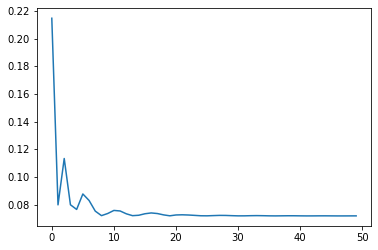

In [7]:
import matplotlib.pyplot as plt

plt.plot(loss_record)
plt.show()